# The Quick and Dirty Model
***Matt Paterson***<br>
***Machine Learning Engineer***<br>
***Santa Cruz, California***<br>
***10/17/2021***<br>

In this challenge, I'll take four csv's with raw data about users of a platform who view videos, review the videos, and also voluntarily submit their interests in the videos, as well as the videos and video authors. 

I will create a model and api that allows an administrator/user (comapny) to input a user_handle (customer) from the existing group of user_handle(s) and get an output of the closest users to the input user_handle.

For the Quick and Dirty model, 
- I will use a simple cosine similarity score for the users based on
    - courses_taken
    - ratings_offered
    - use dummy data for the cold-start problem

I will then create a lookup table in DynamoDB that can store the resulting users table, allowing a RESTful API to query the database through Amazon API Gateway through the depoloyment of an Amazon SageMaker Model Endpoint.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances, cosine_similarity

# Before final push, add any imports that come later in this program to this top box

## Load `course_tags.csv`, `user_assessment_scores.csv`, `user_course_views.csv`, and `user_interests.csv`
---

In [5]:
courses = pd.read_csv('../data/course_tags.csv')
assess = pd.read_csv('../data/user_assessment_scores.csv')
views = pd.read_csv('../data/user_course_views.csv')
interests = pd.read_csv('../data/user_interests.csv')

## Drop unnecessary columns
---

For this first run through, drop all of the null values from courses as there are a small number of them--112/11337

In [6]:
courses = courses.dropna()

## In next iteration: Merge into two dataframes for specific uses
---

## Create a `users_courses` dataframe
**This will be used for our cosine similarity score**
**This should really have the user_handle as an index**
- user_handle
- course_id
- user_assessment_score

## Create a `clusters` dataframe
**This will be used to cluster various user_handles based on their tags**
- user_handle
- interest_tag
- course_tags
- assessment_tag
- view_time_seconds


From here, create a DBScan clustering model and use the clusters from it as an additional feature.<br>

Once completed, run the cosine similarity and create a way to score the users.

---

## For the MVP Model, use the `views` dataframe and the `clusters` dataframe
---
find the cosine similarity of the number of hours of viewing of each course and the user_handle


In [8]:
views.head(3)

,user_handle,view_date,course_id,author_handle,level,view_time_seconds
0,1,2017-06-27,cpt-sp2010-web-designers-branding-intro,875,Beginner,3786
1,1,2017-06-28,cpt-sp2010-web-designers-branding-intro,875,Beginner,1098
2,1,2017-06-28,cpt-sp2010-web-designers-css,875,Intermediate,4406


In [50]:
views['viewing_hours'] = round(views['view_time_seconds'] / 3600, 2)

#### Make a Pivot Table

In [51]:
pivot = pd.pivot_table(views, index='user_handle', columns='course_id', values='viewing_hours')

pivot.head()

course_id,12-principles-animation-toon-boom-harmony-1475,2d-racing-game-series-unity-5-1312,2d-racing-games-unity-volume-2-1286,2d-racing-games-unity-volume-4-1311,3d-coat-character-concept-sculpting-techniques-2526,3d-coat-getting-started-2487,3d-integration-relighting-nuke-1157,3d-models-presenting-online-2385,3d-pan-tile-sky-nuke-81,3d-printing-design-selective-laser-sintering,...,zbrush-mudbox-artists-1416,zbrush-reference-library-3d-brushes-547,zbrush-sculpting-modular-structures-2537,zbrush-sculpting-necroknight-2509,zbrush-tileable-texture-creation-2438,zend-db-deep-dive,zmodeler-workflows-2091,zombie-concept-illustration-photoshop-782,zombie-photo-manipulation-techniques-photoshop-1518,zsphere-modeling-zbrush-3505
user_handle,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Convert to a sparse matrix

In [52]:
sparse_pivot=sparse.csr_matrix(pivot.fillna(0))

## Explore the data

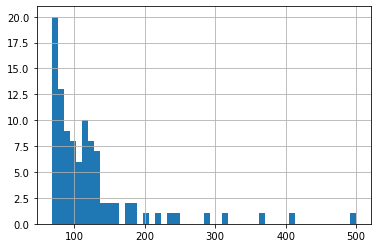

In [53]:
pivot.sum(axis=0).sort_values(ascending=False)[:100].hist(bins=50);

Which courses have the highest viewing times?

In [54]:
pivot.sum(axis=0).sort_values(ascending=False)

course_id
c-sharp-fundamentals-with-visual-studio-2015            500.029723
angular-2-getting-started-update                        412.708741
python-getting-started                                  364.640034
java-fundamentals-language                              317.191518
quick-start-javascript-1-1870                           284.610706
                                                           ...    
civil-3d-designing-pressure-network-models                0.000000
attaching-sculpted-geometry-zbrush-144                    0.000000
photoshop-advanced-tips-tricks-developers                 0.000000
exploring-animation-principles-maya-anticipation-430      0.000000
access-2007-tools                                         0.000000
Length: 5942, dtype: float64

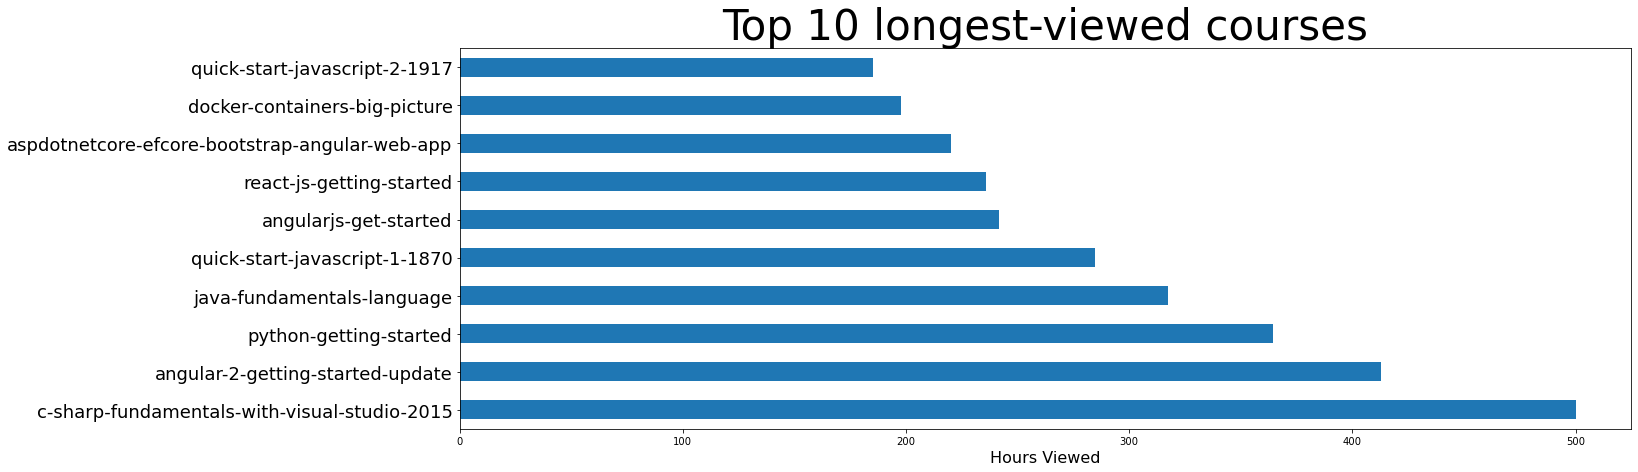

In [55]:
plt.figure(figsize=(21, 7))
pivot.sum(axis=0).sort_values(ascending=False)[:10].plot.barh()
plt.xlabel('Hours Viewed', fontsize=16)
plt.ylabel(ylabel=None)
plt.yticks(fontsize=18)
plt.title("Top 10 longest-viewed courses", fontsize=42);

## Calculate cosine similarity

In [56]:
sims = cosine_similarity(sparse_pivot)

In [57]:
sims_df = pd.DataFrame(sims, columns=pivot.index, index=pivot.index)
sims_df.head()

user_handle,1,2,3,4,5,6,8,9,10,12,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
user_handle,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.0,0.189643,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.158339,0.635105,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,0.000000,1.000000,0.0,0.000000,0.073215,0.000000,0.0,0.0,0.014466,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.007794,0.0,0.0
3,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.442544,0.496139,0.000000,0.0,0.0
4,0.189643,0.000000,0.0,1.000000,0.000000,0.000128,0.0,0.0,0.029164,0.0,...,0.0,0.0,0.000000,0.000000,0.013025,0.131439,0.000000,0.000000,0.0,0.0
5,0.000000,0.073215,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


## Build the dummy API
---
Here let's create a search term, the user_handle, and return

- The user handle being searched
- The nearest 10 user handles to it

In [64]:
search = 9996

for user in views.loc[views['user_handle']==search, 'user_handle']:
    print("You entered user handle:", user)
    print("The closest 10 user handles are:")
    print(sims_df[user].sort_values(ascending=False)[1:11])
    print()

You entered user handle: 9996
The closest 10 user handles are:
user_handle
4357    0.891976
2150    0.891976
7776    0.891976
9525    0.891976
9212    0.891976
2063    0.891976
1146    0.891976
5781    0.891976
7680    0.891976
6323    0.891976
Name: 9996, dtype: float64

You entered user handle: 9996
The closest 10 user handles are:
user_handle
4357    0.891976
2150    0.891976
7776    0.891976
9525    0.891976
9212    0.891976
2063    0.891976
1146    0.891976
5781    0.891976
7680    0.891976
6323    0.891976
Name: 9996, dtype: float64

You entered user handle: 9996
The closest 10 user handles are:
user_handle
4357    0.891976
2150    0.891976
7776    0.891976
9525    0.891976
9212    0.891976
2063    0.891976
1146    0.891976
5781    0.891976
7680    0.891976
6323    0.891976
Name: 9996, dtype: float64

You entered user handle: 9996
The closest 10 user handles are:
user_handle
4357    0.891976
2150    0.891976
7776    0.891976
9525    0.891976
9212    0.891976
2063    0.891976
1146

Now, let's search the assess dataframe for the highest user_assessement_score from each of those users and which assessment tags they gave in those cases

In [95]:
user = 42
assess.loc[[assess.loc[assess['user_handle']==7987]['user_assessment_score'].max()]][['assessment_tag', 'user_assessment_score']]

,assessment_tag,user_assessment_score
131,c-sharp,226


In [116]:
user = 7987
def get_top_score(user):
    try:
        return assess.loc[[assess.loc[assess['user_handle']==user]['user_assessment_score'].max()]][['assessment_tag', 'user_assessment_score']]
    except:
        if user==42:
            return '42, the meaning of life, has no assessments for you to view'
        return 'No Assessments found from this user_handle: {}'.format(user)

In [117]:
get_top_score(user)

,assessment_tag,user_assessment_score
131,c-sharp,226


In [118]:
get_top_score(42)

'42, the meaning of life, has no assessments for you to view'

In [119]:
get_top_score(8943)

,assessment_tag,user_assessment_score
208,html5,166


In [120]:
get_top_score(1)

'No Assessments found from this user_handle: 1'

The new and improved search rating:

In [128]:
search = 42

for user in views.loc[views['user_handle']==search, 'user_handle']:
    print("*"*30)
    print("You entered user handle:", user)
    print("The closest 10 user handles and their cosine similarities are:")
    print(sims_df[user].sort_values(ascending=False)[1:11])   
    print("*"*30)

******************************
You entered user handle: 42
The closest 10 user handles and their cosine similarities are:
user_handle
7709    0.944039
2690    0.944039
7595    0.785488
4510    0.653049
3121    0.621871
3349    0.555424
5788    0.553188
1760    0.522246
1275    0.431039
6189    0.407345
Name: 42, dtype: float64
******************************
******************************
You entered user handle: 42
The closest 10 user handles and their cosine similarities are:
user_handle
7709    0.944039
2690    0.944039
7595    0.785488
4510    0.653049
3121    0.621871
3349    0.555424
5788    0.553188
1760    0.522246
1275    0.431039
6189    0.407345
Name: 42, dtype: float64
******************************
******************************
You entered user handle: 42
The closest 10 user handles and their cosine similarities are:
user_handle
7709    0.944039
2690    0.944039
7595    0.785488
4510    0.653049
3121    0.621871
3349    0.555424
5788    0.553188
1760    0.522246
1275    0.

In [131]:
search = 42
print("*"*30)
print("You entered user handle:", search)
print("The closest 10 user handles and their cosine similarities are:")
print(sims_df[search].sort_values(ascending=False)[1:11])   
print("*"*30)

******************************
You entered user handle: 42
The closest 10 user handles and their cosine similarities are:
user_handle
7709    0.944039
2690    0.944039
7595    0.785488
4510    0.653049
3121    0.621871
3349    0.555424
5788    0.553188
1760    0.522246
1275    0.431039
6189    0.407345
Name: 42, dtype: float64
******************************


In [134]:
sims_df.to_csv('s3://mp-pluralsight-demo-20211016/data/sims_df')

In [135]:
sims_df.shape

(8760, 8760)

## Save the dataframe to csv and consider DynamoDB, SQLite, PostreSQL, and AWS RDS
***Also create a set of lambda functions to be performed when the API is called***

In [150]:
print('Hello')

Hello
